In [1]:
from collections import Counter
import regex as re
import numpy as np 
import pandas as pd

# Load Dataset

In [2]:
word_dict=[]
with open('/kaggle/input/test-file/hi_hdtb-ud-train.conllu') as f:
    
    # Initialize an index variable i
    i=0

    # Initialize a list to store words
    word_dict=[]

    # Iterate through each line in the file
    for line in f.readlines():
        # Split the line by tab character ('\t')
        sp = line.strip().split('\t')

        # Check if the line contains 10 elements
        if len(sp) == 10:
            # Append the TOKEN to the word_dict list
            word_dict.append(sp[1])
        
# Create a Counter object
word_freq = Counter(word_dict)


# Part 1: Replicate 

In [3]:
def calculate_probability(sentence, total_word_frequency=sum(word_freq.values())):
    "Probability of `sentence`."
    words = sentence.split()
    return sum(word_freq[word] for word in words) / total_word_frequency

def spelling_correction(word):
    "Most probable spelling correction for word."
    return max(generate_candidates(word), key=calculate_probability)

def sentence_correction(sentence):
    "Most probable spelling correction for sentence."
    return ' '.join([spelling_correction(word) for word in sentence.split()])

def generate_candidates(word):
    "Generate possible spelling corrections for word."
    return (get_known([word]) or get_known(candidate_word(word)) or [word])

def get_known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in word_freq)

def candidate_word(word):
    "All edits that are one edit away from `word`."
    letters = 'ःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎॏॐ॒॑॓॔ॕॖॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡॢॣ'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [L + R[1:] for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
    replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
    inserts = [L + c + R for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

input_sentence = "सन 1855 में मंदि का निर्माण पुर हुआ ।"
corrected_sentence = sentence_correction(input_sentence)
print(f"Input Sentence: {input_sentence}")
print(f"Corrected Sentence: {corrected_sentence}")


Input Sentence: सन 1855 में मंदि का निर्माण पुर हुआ ।
Corrected Sentence: सन 185 में मंदिर का निर्माण पर हुआ ।


In [4]:

input_sentence = "यह गर्म पानी और ठंडे पनी के दो बहत ही उत्तम कुंध हैं ।"
corrected_sentence = sentence_correction(input_sentence)
print(f"Input Sentence: {input_sentence}")
print(f"Corrected Sentence: {corrected_sentence}")

Input Sentence: यह गर्म पानी और ठंडे पनी के दो बहत ही उत्तम कुंध हैं ।
Corrected Sentence: यह गर्म पानी और ठंडे अपनी के दो बात ही उत्तम धुंध हैं ।


# Shared Bi-grams

In [5]:
def calculate_probability(word, word_frequency_sum=sum(word_freq.values())):
    """Calculate the probability of a word."""
    return word_freq[word] / word_frequency_sum

def generate_edits_2(word):
    probability_word = []
    original_splits = [(word[:i], word[i:]) for i in range(len(word) + 1)] # Here I have split the words into bi-gram characters
    original_flattened_splits = [item for sublist in original_splits for item in sublist]
    original_flattened_splits = set(original_flattened_splits)

    for edit_1 in candidate_word(word):
        """splits these candidate words into character bigrams and finds overlaps with the original word's bigrams"""
        if calculate_probability(edit_1) != 0:
            splits = [(edit_1[:i], edit_1[i:]) for i in range(len(edit_1) + 1)]

            flattened_splits = [item for sublist in splits for item in sublist]
            flattened_splits = set(flattened_splits)
            shared_count = sum(1 for split in flattened_splits if split in original_flattened_splits)
            probability = calculate_probability(edit_1) + shared_count
            probability_word.append((edit_1, probability))
    return probability_word

def sort_probability_word(probability_word):
    """Sort the list of words based on probability in descending order."""
    probability_word_result = sorted(probability_word, key=lambda x: x[1], reverse=True)
    max_probability_word = max(probability_word_result, key=lambda x: x[1])[0]
    return max_probability_word

def sentence_spell_correct(sentence):
    """Spell correct a sentence."""
    corrected_sentence = []
    for word in sentence.split():
        # Check for specified Hindi punctuation
        if word in ['।', ';', ',', '!', '?', ':', ';', '-', '_', '"', '\'']:
            corrected_word = word
        else:
            if word not in word_freq:
                corrected_word = sort_probability_word(generate_edits_2(word))
            else:
                corrected_word=word
        corrected_sentence.append(corrected_word)

    # Remove occurrences of "पूर्ण विराम" if they occur in the middle of sentences
    corrected_sentence = re.sub(r'\s+।\s+', ' ', ' '.join(corrected_sentence))

    return corrected_sentence

# Example usage
input_sentence = "यह गर्म पानी और ठंडे पनी के दो बहत ही उत्तम कुंध हैं ।"
result = sentence_spell_correct(input_sentence)
print(result)


यह गर्म पानी और ठंडे अपनी के दो बहुत ही उत्तम धुंध हैं ।


In [6]:
word='बहत'
original_splits = [(word[:i], word[i:]) for i in range(len(word) + 1)] 
print(original_splits)

[('', 'बहत'), ('ब', 'हत'), ('बह', 'त'), ('बहत', '')]


In [7]:
word='बहुत'
original_splits = [(word[:i], word[i:]) for i in range(len(word) + 1)] 
print(original_splits)

[('', 'बहुत'), ('ब', 'हुत'), ('बह', 'ुत'), ('बहु', 'त'), ('बहुत', '')]


# Generate Synthetic Dataset 

In [8]:
import re
import pandas as pd
train_text = []

with open('/kaggle/input/test-file/hi_hdtb-ud-train.conllu') as f:
    for line in f:
        if line.startswith('# text ='):
            train_text.append(re.sub(r'^# text = ', '', line.strip()))
            

In [9]:
import random
import string

def change_context(text):
    words = text.split()
    random.shuffle(words)
    shuffled_text = ' '.join(words)
    return shuffled_text
def add_noise(text, noise_percentage=30):
    words = text.split()
    num_words_to_change = int(len(words) * (noise_percentage / 100))

    for _ in range(num_words_to_change):
        index_to_change = random.randint(0, len(words) - 1)
        word_to_change = words[index_to_change]
        candidate_words = candidate_word(word_to_change)
        
        # Exclude the original word from the candidate list to avoid replacing with itself
        candidate_words.discard(word_to_change)
        
        if candidate_words:
            new_word = random.choice(list(candidate_words))
            words[index_to_change] = new_word

    noisy_text = ' '.join(words)
    return noisy_text


In [10]:
# Example usage
input_text = "यह एक उदाहरण है"
changed_context_text = change_context(input_text)
noisy_text = add_noise(input_text)

print(f"Input Text: {input_text}")
print(f"Changed Context Text: {changed_context_text}")
print(f"Noisy Text: {noisy_text}")

Input Text: यह एक उदाहरण है
Changed Context Text: उदाहरण एक है यह
Noisy Text: यह एक उदाहभण है


In [11]:
# Creating a DataFrame
data = {'text': train_text}
df = pd.DataFrame(data)

# Adding a 'label' column
df['label'] = 1  # 1 represents correct (non-noisy) text

# Creating a new DataFrame for noisy versions
df_noisy_1= pd.DataFrame()
df_noisy_1['text'] =df['text'].apply(change_context)
df_noisy_1['label']=0

result_df = pd.concat([df, df_noisy_1], ignore_index=True)

# Creating a new DataFrame for noisy versions
df_noisy_2= pd.DataFrame()

df_noisy_2['text'] =df['text'].apply(add_noise)

df_noisy_2['label']=0

result_df1 = pd.concat([result_df, df_noisy_2], ignore_index=True)
#result_df1.to_pickle('hindi_synthethic_data.pkl')

# BERT Model

>  Code reference: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [12]:
import pandas as pd
file_path = "/kaggle/input/hindi-checker/hindi_synthethic_data.pkl"

# Load the DataFrame from the pickle file
df = pd.read_pickle(file_path)

In [13]:
df

,text,label
0,यह एशिया की सबसे बड़ी मस्जिदों में से एक है ।,1
1,इसे नवाब शाहजेहन ने बनवाया था ।,1
2,इसका प्रवेश द्वार दो मंजिला है ।,1
3,जिसमें चार मेहराबें हैं और मुख्य प्रार्थना हॉल...,1
4,पूरी इमारत बेहद खूबसूरत है ।,1
...,...,...
39913,उन्होंने कहा कि चीन तिब्बत ॠको व्यापक स्वायत्त...,0
39914,दलाई लामा ने भारत और षचीन के रिशकते में आ रहे ...,0
39915,उन्होंने कहा कभ सभारत और चीन सर्वाधिक आबादी वा...,0
39916,इन दोनों देखों के बीच रिश्ते मेॆज सुधार से करो...,0


In [14]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [15]:

#!pip install git+https://github.com/huggingface/transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Example Hindi sentence
hindi_sentence = 'यह एक उदाहरण है।'

# Load the pre-trained model and tokenizer for Hindi
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-multilingual-cased")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Tokenize the sentence
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(hindi_sentence)))
print("Tokens:", tokens)

# Encode the tokens
input_ids = tokenizer.encode(hindi_sentence, return_tensors="pt")
print("Input IDs:", input_ids)

Tokens: ['[CLS]', 'यह', 'एक', 'उदाहरण', 'है', '।', '[SEP]']
Input IDs: tensor([[  101, 13525, 11186, 77170, 10569,   920,   102]])


In [17]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.label.values

In [18]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  यह एशिया की सबसे बड़ी मस्जिदों में से एक है ।
Token IDs: tensor([  101, 13525,   860, 87084, 10826, 28603, 76923,   889, 13432, 73649,
        12878, 15552, 11497, 10532, 11072, 11186, 10569,   920,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [19]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 70-30 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

27,942 training samples
11,976 validation samples


In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report

batch_size = 32

# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification for Hindi
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",  # Use the multilingual BERT model for Hindi
    num_labels=2,  # Adjust the number of output labels based on your task
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [22]:

optimizer = AdamW(model.parameters(),
                  lr = 3e-5, 
                  eps = 1e-8,
                  weight_decay = 0.01
                )


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [26]:
import random
import numpy as np


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

   

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

      
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

    
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
       
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


        
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss=outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    y_true=[]
    y_pred=[]
    # Evaluate data for one epoch
    for batch in validation_dataloader:

       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():


            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss=outputs[0]
            logits=outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        preds = np.argmax(logits, axis=1)
        # Append true and predicted labels for the current batch
        y_true.extend(label_ids)
        y_pred.extend(preds)

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

report = classification_report(y_true, y_pred)

# Print the classification report
print("Classification Report:\n", report)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    874.    Elapsed: 0:00:18.
  Batch    80  of    874.    Elapsed: 0:00:34.
  Batch   120  of    874.    Elapsed: 0:00:49.
  Batch   160  of    874.    Elapsed: 0:01:03.
  Batch   200  of    874.    Elapsed: 0:01:18.
  Batch   240  of    874.    Elapsed: 0:01:33.
  Batch   280  of    874.    Elapsed: 0:01:48.
  Batch   320  of    874.    Elapsed: 0:02:03.
  Batch   360  of    874.    Elapsed: 0:02:18.
  Batch   400  of    874.    Elapsed: 0:02:33.
  Batch   440  of    874.    Elapsed: 0:02:48.
  Batch   480  of    874.    Elapsed: 0:03:03.
  Batch   520  of    874.    Elapsed: 0:03:18.
  Batch   560  of    874.    Elapsed: 0:03:33.
  Batch   600  of    874.    Elapsed: 0:03:48.
  Batch   640  of    874.    Elapsed: 0:04:03.
  Batch   680  of    874.    Elapsed: 0:04:18.
  Batch   720  of    874.    Elapsed: 0:04:33.
  Batch   760  of    874.    Elapsed: 0:04:48.
  Batch   800  of    874.    Elapsed: 0:05:03.
  Batch   840  of

# Evaluation 

In [27]:
import pandas as pd

pd.set_option('display.precision', 2)


df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,5.63e-02,0.03,0.99,0:05:31,0:00:45
2,2.14e-02,0.04,0.99,0:05:27,0:00:45
3,9.52e-03,0.05,0.99,0:05:28,0:00:45
4,3.49e-03,0.05,0.99,0:05:27,0:00:45


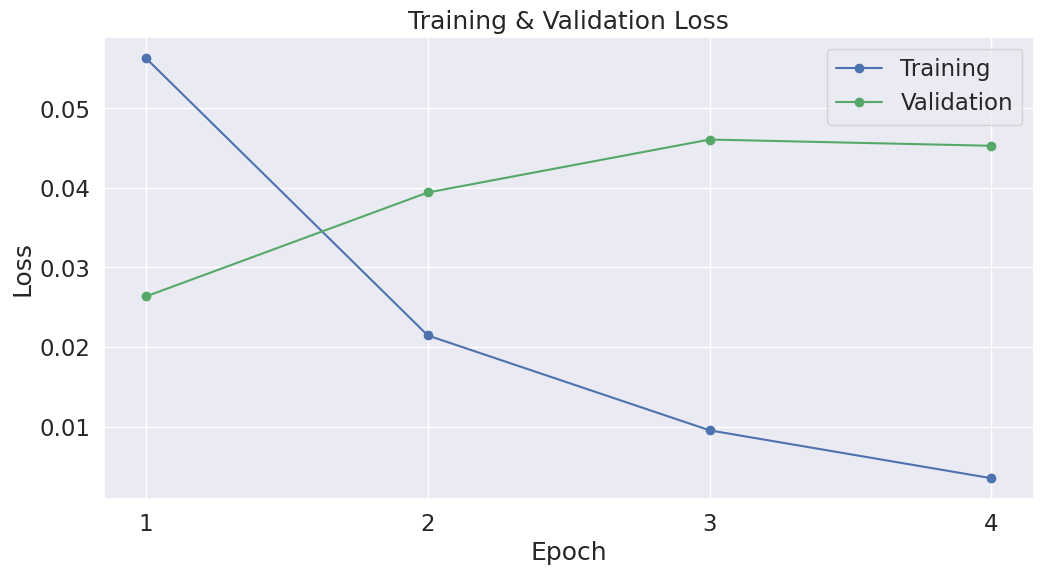

In [28]:
import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3,4])
plt.savefig('training_validation_loss_plot.png')
plt.show()

In [29]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')

In [30]:
!pip install transformers

from transformers import BertForSequenceClassification

output_dir = '/kaggle/input/hindi-checker/model/content/model_save'

print(output_dir)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/kaggle/input/hindi-checker/model/content/model_save


In [31]:
from transformers import BertTokenizer
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [32]:
import re
import pandas as pd
test_text = []

with open('/kaggle/input/test-file/hi_hdtb-ud-test.conllu') as f:
    for line in f:
        if line.startswith('# text ='):
            test_text.append(re.sub(r'^# text = ', '', line.strip()))

In [139]:
def add_noise1(text, noise_percentage=30):
    words = text.split()
    num_words_to_change = int(len(words) * (noise_percentage / 100))

    for _ in range(num_words_to_change):
        index_to_change = random.randint(0, len(words) - 1)
        word_to_change = words[index_to_change]
        candidate_words = candidate_word(word_to_change)
        
        # Skip if the word is a number or punctuation
        if word_to_change.isdigit() or all(char in string.punctuation for char in word_to_change):
            continue
        
        # Exclude the original word from the candidate list to avoid replacing with itself
        candidate_words.discard(word_to_change)
        
        if candidate_words:
            new_word = random.choice(list(candidate_words))
            words[index_to_change] = new_word

    noisy_text = ' '.join(words)
    return noisy_text


In [140]:
# Apply noise to 50% of the sentences
noisy_sentences = []
actual_sentences = []

for sentence in test_text:
        noisy_sentence = add_noise1(sentence, noise_percentage=30)
        noisy_sentences.append(noisy_sentence)
        actual_sentences.append(sentence)  # 1 indicates that the sentence has noise

# Create a DataFrame
test_df = pd.DataFrame({'Noisy_sentences': noisy_sentences, 'Actual_sentences': actual_sentences})

In [135]:
test_df

,Noisy_sentences,Actual_sentences
0,"इसके अॄतिरिक्त गुग्गुल कुंड, भीम गुफा तथाऴ भीम...","इसके अतिरिक्त गुग्गुल कुंड, भीम गुफा तथा भीमशि..."
1,"आधऌ किमी की दूरी पर भैरवनाथ मंदिर हैब, जहाँ के...","आधा किमी की दूरी पर भैरवनाथ मंदिर है, जहाँ केव..."
2,भैरव का स्थबान उत्तराखंड में क्षेतोहरपाल अथवा ...,भैरव का स्थान उत्तराखंड में क्षेत्रपाल अथवा भू...
3,ऒयह सोनप्रयाग ऑे 5 किमी आगे और केदारनाथ में 6 ...,यह सोनप्रयाग से 5 किमी आगे और केदारनाथ में 6 क...
4,इसकीृ ऊँचाई केवल 1982 मीटर है ।,इसकी ऊँचाई केवल 1982 मीटर है ।
...,...,...
1679,इस खुशी ाें अकबर नेफ इस दरगाह क॒ 4800 किलोग्रा...,इस खुशी में अकबर ने इस दरगाह को 4800 किलोग्राम...
1680,अईी भरी यह कड़ाह इस्तेमाल में है ऄ।,अभी भी यह कड़ाह इस्तेमाल में है ।
1681,सम्राट जहांगृीॎ ने कई बार इस दरगाह की यात्रा क...,सम्राट जहांगीर ने कई बार इस दरगाह की यात्रा की...
1682,ॠएक यात्रा अकऊ दौरान जहांगीर बीमार पड़॓ ोए तो ...,एक यात्रा के दौरान जहांगीर बीमार पड़ गए तो उन्...


In [39]:
model_loaded.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [40]:
import string
def getLevenshteinDistance(s, t):
    rows = len(s)+1
    cols = len(t)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]
    for i in range(1, rows):
        dist[i][0] = i
        
        
    for i in range(1, cols):
        dist[0][i] = i
        
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0
            else:
                cost = 1
            dist[row][col] = min(dist[row-1][col] + 1,      # deletion
                                 dist[row][col-1] + 1,      # insertion
                                 dist[row-1][col-1] + cost) # substitution

    return dist[row][col]


def generate_edits_2(word):
    probability_word = []
    original_splits = [(word[:i], word[i:]) for i in range(len(word) + 1)] # Here I have split the words into bi-gram characters
    original_flattened_splits = [item for sublist in original_splits for item in sublist]
    original_flattened_splits = set(original_flattened_splits)
    #print(original_flattened_splits)

    for edit_1 in candidate_word(word):
        """splits these candidate words into character bigrams and finds overlaps with the original word's bigrams"""
        if calculate_probability(edit_1) != 0:
            splits = [(edit_1[:i], edit_1[i:]) for i in range(len(edit_1) + 1)]

            flattened_splits = [item for sublist in splits for item in sublist]
            flattened_splits = set(flattened_splits)
            #print(flattened_splits)
            shared_count = sum(1 for split in flattened_splits if split in original_flattened_splits)
            probability = calculate_probability(edit_1)
            #print()
            probability_word.append((edit_1, probability,shared_count))
    return probability_word


def sentence_spell_correct(sentence):
    corrected_sentence = sentence
    words = sentence.split()

    for i, word in enumerate(words):
        
        if re.match(r'^[0-9]+$', word) or word in string.punctuation:
            continue
            
        if not word_freq[word]:
            candidates_info = generate_edits_2(word)
            if candidates_info:
                # Get candidate words based on edits2
                candidate_words = [x[0] for x in generate_edits_2(word)]


                # Initialize a list to store the probability for each candidate
                predictions = []

                # Generate all possible sentences with candidate words
                for candidate, freq_prob,shared_count in candidates_info:
                    
                    #print((candidate,freq_prob))

                    # Create a new list to store the modified sentence
                    modified_sentence = words.copy()
                    modified_sentence[i] = candidate

                    # Join the modified sentence and check for spelling
                    possible_sentence = ' '.join(modified_sentence)


                    # Make predictions for each possible sentence using the BERT model
                    encoded_dict = tokenizer.encode_plus(
                        possible_sentence,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt'
                    )
                    input_id = encoded_dict['input_ids'].to(device)
                    attention_mask = encoded_dict['attention_mask'].to(device)

                    with torch.no_grad():
                        outputs = model_loaded(input_id, attention_mask)

                    logits = outputs.logits
                    probabilities = torch.nn.functional.softmax(logits, dim=1)

                    probability_pos = probabilities[0][1].item()
                    final_prob=2.5*probability_pos+0.8*freq_prob+3*shared_count
#                     print(candidate,probability_pos,freq_prob,shared_count)
#                     print(final_prob)
#                     print()

                # Append the probability for the current candidate
                    predictions.append(final_prob)

                # Choose the candidate with the most predicted positive labels
                best_candidate_index = predictions.index(max(predictions))
                best_candidate = candidate_words[best_candidate_index]
              
                # Replace the word in the corrected sentence
                words[i] = best_candidate
            else:
                min_dis=100
                correct_word=""
                for s in word_dict:
                    cur_dis = getLevenshteinDistance(s,word)
                    if min_dis > cur_dis :
                        min_dis = cur_dis
                        correct_word = s
                        
                words[i]=correct_word
            

    return ' '.join(words)

In [41]:
input_sentence = "वहाा गोवा हैं ।"
result = sentence_spell_correct(input_sentence)
print(result)

वहाँ गोवा हैं ।


In [42]:
input_sentence = "सन 1855 में मंदिर का निर्माण पुर हुआ ।"
result = sentence_spell_correct(input_sentence)
print(result)

सन 1855 में मंदिर का निर्माण पुरी हुआ ।


In [101]:
input_sentence = "यह गर्म पानी और ठंडे पनी के दो बहत ही उत्तम कुंध हैं ।"
result = sentence_spell_correct(input_sentence)
print(result)

यह गर्म पानी और ठंडे पानी के दो बहुत ही उत्तम कुंए हैं ।


In [44]:
input_sentence = "आजे रात रारिश हैं।"
result = sentence_spell_correct(input_sentence)
print(result)

आज रात बारिश हैं


In [ ]:
def calculate_wer(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    # Counting the number of substitutions, deletions, and insertions
    substitutions = sum(1 for ref, hyp in zip(ref_words, hyp_words) if ref != hyp)
    deletions = len(ref_words) - len(hyp_words)
    insertions = len(hyp_words) - len(ref_words)
    # Total number of words in the reference text
    total_words = len(ref_words)
    # Calculating the Word Error Rate (WER)
    wer = (substitutions + deletions + insertions) / total_words
    return wer

In [49]:
import itertools

In [141]:
def top_3_suggestion(incorrect_sentence,actual_sentence):
    words = incorrect_sentence.split()
    
    ref_words = actual_sentence.split()

    
    top_1=0
    top_3=0
    
    count=0

    for i, word in enumerate(words):
        if word ==ref_words[i]:
            continue
    
        if re.match(r'^[0-9]+$', word) or word in string.punctuation:
            continue
            
        if not word_freq[word]:
            candidates_info = generate_edits_2(word)
            if candidates_info:
                # Get candidate words based on edits2
                candidate_words = [x[0] for x in generate_edits_2(word)]

                # Initialize a list to store the probability for each candidate
                predictions = []

                # Initialize a list to store the top three candidates
                top_three_candidates = []

                # Generate all possible sentences with candidate words
                for candidate, freq_prob, shared_count in candidates_info:
                    modified_sentence = words.copy()
                    modified_sentence[i] = candidate
                    possible_sentence = ' '.join(modified_sentence)

                    encoded_dict = tokenizer.encode_plus(
                        possible_sentence,
                        add_special_tokens=True,
                        max_length=64,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt'
                    )
                    input_id = encoded_dict['input_ids'].to(device)
                    attention_mask = encoded_dict['attention_mask'].to(device)

                    with torch.no_grad():
                        outputs = model_loaded(input_id, attention_mask)

                    logits = outputs.logits
                    probabilities = torch.nn.functional.softmax(logits, dim=1)
                    probability_pos = probabilities[0][1].item()
                    final_prob = 2.5 * probability_pos + 0.8 * freq_prob + 3 * shared_count

                    # Append the probability for the current candidate
                    predictions.append(final_prob)

                    # Append the candidate to the top three list
                    top_three_candidates.append((candidate, final_prob))

                # Sort top three candidates by probability in descending order
                top_three_candidates = sorted(top_three_candidates, key=lambda x: x[1], reverse=True)[:3]
             
                best_candidate = top_three_candidates[0][0]
            
                #top-1 
#                 print(ref_words[i])
#                 print(top_three_candidates)
                if best_candidate == ref_words[i]:
                    top_1+=1
                if ref_words[i] in [candidate for candidate, _ in top_three_candidates]:
                    top_3 += 1
                    
                count+=1
                

                # Choose the candidate with the most predicted positive labels
                best_candidate_index = predictions.index(max(predictions))
                best_candidate = candidate_words[best_candidate_index]
              
                # Replace the word in the corrected sentence
                words[i] = best_candidate
    
              
            else:
                # Your existing code for handling words not in the word_freq dictionary
                min_dis = 100
                correct_word = ""
                suggestions=[]
                for s in word_dict:
                    cur_dis = getLevenshteinDistance(s, word)
                    suggestions.append((s, cur_dis))
                count+=1
                sorted_suggestions = sorted(suggestions, key=lambda x: x[1])

                # Get the top k suggestions
                top_k_suggestions = [suggestion[0] for suggestion in sorted_suggestions[:3]]
                best_suggestion = top_k_suggestions[0]

                # Top-1 accuracy
                if best_suggestion == ref_words[i]:
                    top_1 += 1

                # Top-3 accuracy
                if ref_words[i] in top_k_suggestions:
                    top_3 += 1
                words[i] = best_suggestion

    if count==0:
        top_1_accuray=100
        top_3_accuracy=100
    else:

        top_1_accuray=(top_1/count)*100
        top_3_accuracy=(top_3/count)*100
    return ' '.join(words), top_1_accuray, top_3_accuracy

In [142]:
from tqdm import tqdm

# Initialize an emptylist to store results
wer_results = []
filtered_test_df = test_df[test_df['Noisy_sentences'].apply(len) < 60] # as my model can only understand sentence length upto 64
filtered_test=filtered_test_df.head(100)
# Iterate through each row in the filtered_test_df
for _, row in tqdm(filtered_test.iterrows(), total=len(filtered_test), desc="Processing Rows"):
    noisy_sentence = row['Noisy_sentences']
    actual_sentence = row['Actual_sentences']

    # Predict the corrected sentence using your sentence_spell_correct function
    corrected_sentence,top_1_acc,top_3_acc = top_3_suggestion(noisy_sentence,actual_sentence)

    # Store the results
    wer_results.append({'Noisy_sentence': noisy_sentence, 'Actual_sentence': actual_sentence, 'Corrected_sentence': corrected_sentence, 'Top_1_accuracy': top_1_acc,'Top_3_accuracy':top_3_acc})
wer_df = pd.DataFrame(wer_results)

Processing Rows:   0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Processing Rows: 100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


In [144]:
wer_df.to_csv('top_k_accuracy.csv',index=False)

In [145]:
wer_df

,Noisy_sentence,Actual_sentence,Corrected_sentence,Top_1_accuracy,Top_3_accuracy
0,इसकी ऊँचऌाई केवल 1982 मीटर हव ।,इसकी ऊँचाई केवल 1982 मीटर है ।,इसकी ऊँचाई केवल 1982 मीटर हवा ।,50.00,50.00
1,"यहाँ गौरी मॅंदिर है, जो कळुछ छोटा है और प्राची...","यहाँ गौरी मंदिर है, जो कुछ छोटा है और प्राचीन ...","यहाँ गौरी मंदिर है, जो कुछ छोटा है और प्राचीन ...",100.00,100.00
2,मंदिर में गौरी और पार्वती की धातु ॣफकी मूर्तिय...,मंदिर में गौरी और पार्वती की धातु की मूर्तियाँ...,मंदिर में गौरी और पार्वती की धातु की मूर्तियाँ...,100.00,100.00
3,मंदिर केय गर्भगृह मेंई नारायण भगवान की सुंदर म...,मंदिर के गर्भगृह में नारायण भगवान की सुंदर मूर...,मंदिर केयर गर्भगृह में नारायण भगवान की सुंदर म...,66.67,100.00
4,यहाँ अनेक कृुंड भी हैं ।,यहाँ अनेक कुंड भी हैं ।,यहाँ अनेक कुंड भी हैं ।,100.00,100.00
...,...,...,...,...,...
95,वह ़सत्तारूढ़ संप्रग सरकार कीॣ अध्यक्ष हैं ।,वह सत्तारूढ़ संप्रग सरकार की अध्यक्ष हैं ।,वह सत्तारूढ़ संप्रग सरकार की अध्यक्ष हैं ।,100.00,100.00
96,उन्हें न्यौता दनिया गया है ।,उन्हें न्यौता दिया गया है ।,उन्हें न्यौता दुनिया गया है ।,0.00,100.00
97,इसमें जीत राजग की हो॑ी ।,इसमें जीत राजग की होगी ।,इसमें जीत राजग की होगी ।,100.00,100.00
98,इसलिए उन्हें मॠ. डिपेंडेबल की संज्ञा दी जा वकत...,इसलिए उन्हें मि. डिपेंडेबल की संज्ञा दी जा सकत...,इसलिए उन्हें में डिपेंडेबल की संज्ञा दी जा सकत...,66.67,66.67


In [146]:
wer_df['Top_1_accuracy'].sum()

7241.666666666667

In [148]:
total_rows=len(wer_df)
overall_top_1_accuracy = (wer_df['Top_1_accuracy'].sum()/ total_rows)
overall_top_3_accuracy = (wer_df['Top_3_accuracy'].sum()/ total_rows)

# Print or use the overall accuracies as needed
print("Overall Top-1 Accuracy: {:.2f}%".format(overall_top_1_accuracy))
print("Overall Top-3 Accuracy: {:.2f}%".format(overall_top_3_accuracy))

Overall Top-1 Accuracy: 72.42%
Overall Top-3 Accuracy: 83.17%


In [ ]:
from tqdm import tqdm

# Initialize an emptylist to store results
wer_results = []
filtered_test_df = test_df[test_df['Noisy_sentences'].apply(len) < 60] # as my model can only understand sentence length upto 64
filtered_test=filtered_test_df.head(50)
# Iterate through each row in the filtered_test_df
for _, row in tqdm(filtered_test.iterrows(), total=len(filtered_test), desc="Processing Rows"):
    noisy_sentence = row['Noisy_sentences']
    actual_sentence = row['Actual_sentences']

    # Predict the corrected sentence using your sentence_spell_correct function
    corrected_sentence = sentence_spell_correct(noisy_sentence)
    # Calculate Word Error Rate (WER)
    wer = calculate_wer(actual_sentence, corrected_sentence)
    # Store the results
    wer_results.append({'Noisy_sentence': noisy_sentence, 'Actual_sentence': actual_sentence, 'Corrected_sentence': corrected_sentence, 'WER': wer})


wer_df = pd.DataFrame(wer_results)

In [ ]:
wer_df.to_csv('Noisy_text_sentence_prediction.csv',index=False)

In [ ]:
high_wer_df = wer_df[wer_df['WER'] > 0.2]

In [ ]:
len(high_wer_df)